# LSMS Linear Regression 
Predict farm-level yields using vegetation index measures.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns; sns.set()

In [3]:
df1 = pd.read_csv('Feb_Apr_2015_Training_Data.csv')
df1['Year'] = '2015'
df2 = pd.read_csv('Feb_Apr_2011_Training_Data.csv')
df2['Year'] = '2011'
df3 = pd.read_csv('Feb_Apr_2013_Training_Data.csv')
df3['Year'] = '2013'

In [4]:
df1.shape

(25496, 20)

In [5]:
df2.shape

(4001, 21)

In [6]:
df3.shape

(26385, 21)

In [7]:
crops_to_select = ['Barley','Maize','Sorghum','Teff','Wheat']

In [8]:
df = df1.append(df2).append(df3)
df = df.reset_index()

/anaconda3/envs/p37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
df.shape[0] == df1.shape[0] + df2.shape[0] + df3.shape[0]

True

In [10]:
df = df[df['Crop Name'].isin(crops_to_select)]

In [11]:
del(df['.geo'])

In [12]:
crops_encoded = pd.get_dummies(pd.DataFrame(df['Crop Name']))
crop_cols = list(crops_encoded.columns)

In [13]:
df.shape

(21887, 21)

In [14]:
def gen_logs_dummies(df):
    VI_means = [i for i in list(df.columns) if 'mean' in i]

    for vi in VI_means:
        df[f"log_{vi}"] = df[vi].apply(lambda x: np.log(x))
        
    crops_encoded = pd.get_dummies(pd.DataFrame(df['Crop Name']))
    year_encoded = pd.get_dummies(pd.DataFrame(df['Year']))
    
    df = df.merge(year_encoded, left_index=True, right_index=True)
    df = df.merge(crops_encoded, left_index=True, right_index=True)
    
    return df

In [15]:
df = gen_logs_dummies(df)

In [16]:
df.shape

(21887, 34)

In [17]:
areas = pd.DataFrame(df['Area (Normalized)'])

In [18]:
avg_field_size = round(np.nanmean(df['Area (Normalized)'])/10000,2)

In [19]:
print(f"Average field size is {avg_field_size} hectares (when reported).")

Average field size is 6.61 hectares (when reported).


In [20]:
x_2015 = df[df['Year']=='2015']
x_2015 = x_2015[x_2015['Crop Name'].isin(crops_to_select)]


In [21]:
crop_cols[:-1]

['Crop Name_Barley', 'Crop Name_Maize', 'Crop Name_Sorghum', 'Crop Name_Teff']

In [22]:
base_x_cols = [#'log_NDVI_mean', 
               #'log_mean_EVI', 
               #'log_TVI_mean', 
               #'log_GCVI_mean', 
               #'EVI_variance', 
               #'NDVI_variance', 
               #'TVI_variance', 
               #'GCVI_variance',
               #'NDVI_mean',
               'EVI_mean',
               #'GCVI_mean',
               'TVI_mean',
               'Year_2011',
               'Year_2013']#,
               #'Year_2015']
all_x_cols = base_x_cols + crop_cols[:-1]
y_col = ['Quantity (kg)']

In [23]:
cols_ = base_x_cols

In [24]:
df_ = df[y_col + all_x_cols]

print(f"There are {df_.shape[0]} observations prior to removing NAs")
df_ = df_.dropna()
print(f"There are {df_.shape[0]} observations after removing NAs")

y = df_[y_col]
x = df_[cols_]

There are 21887 observations prior to removing NAs
There are 20308 observations after removing NAs


In [25]:
y.describe()

,Quantity (kg)
count,20308.000000
mean,143.422476
std,183.051145
min,0.000000
25%,18.260000
50%,77.714002
75%,200.000000
max,1000.000000


In [26]:
x.describe()

,EVI_mean,TVI_mean,Year_2011,Year_2013
count,20308.000000,20308.000000,20308.000000,20308.000000
mean,0.208146,6.363893,0.078590,0.474542
std,0.087726,3.335135,0.269104,0.499364
min,0.064499,1.078087,0.000000,0.000000
25%,0.148917,4.084324,0.000000,0.000000
50%,0.189261,5.613338,0.000000,0.000000
75%,0.244686,7.787534,0.000000,1.000000
max,0.653160,24.150724,1.000000,1.000000


In [27]:
mod = sm.OLS(y,x)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          Quantity (kg)   R-squared (uncentered):                   0.377
Model:                            OLS   Adj. R-squared (uncentered):              0.377
Method:                 Least Squares   F-statistic:                              3075.
Date:                Sun, 06 Oct 2019   Prob (F-statistic):                        0.00
Time:                        11:09:43   Log-Likelihood:                     -1.3467e+05
No. Observations:               20308   AIC:                                  2.693e+05
Df Residuals:                   20304   BIC:                                  2.694e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Total predicted yield in 2015 (for farms):

In [28]:
np.nanmean(res.predict(x))

137.73182008981868

Total actual yield in 2015 (for farms):

In [29]:
y.sum()['Quantity (kg)']

2912623.6504040356

## Predictions

In [30]:
def get_region(region,df):
    return df[df['region_zone_woreda'].str.contains(region)]

SET REGION:

In [31]:
region = 'All'

In [32]:
if region == 'All':
    sub_region = False
else:
    sub_region = True

if sub_region == True:
    x_2015 = get_region(region,x_2015)
x_2015 = x_2015[cols_]

_df = pd.read_csv('Feb_Apr_2016_Forecast_Data.csv')
_df['Year_2011'] = 0
_df['Year_2013'] = 0
if sub_region == True:
    _df = get_region(region, _df)
_df = gen_logs_dummies(_df)
_df = _df[_df['Crop Name'].isin(crops_to_select)]
x_2016 = _df[cols_]

_df = pd.read_csv('Feb_Apr_2017_Forecast_Data.csv')
_df['Year_2011'] = 0
_df['Year_2013'] = 0
if sub_region == True:
    _df = get_region(region, _df)
_df = gen_logs_dummies(_df)
_df = _df[_df['Crop Name'].isin(crops_to_select)]
x_2017 = _df[cols_]

_df = pd.read_csv('Feb_Apr_2018_Forecast_Data.csv')
_df['Year_2011'] = 0
_df['Year_2013'] = 0
if sub_region == True:
    _df = get_region(region, _df)
_df = gen_logs_dummies(_df)
_df = _df[_df['Crop Name'].isin(crops_to_select)]
x_2018 = _df[cols_]

In [33]:
if region == 'oro':
    region = 'Oromia'
if region == 'gamb':
    region = 'Gambela'

In [34]:
x_2015.shape == x_2016.shape == x_2017.shape == x_2018.shape

True

In [35]:
y_15 = np.nanmean(res.predict(x_2015))

In [36]:
y_16 = np.nanmean(res.predict(x_2016))

In [37]:
y_17 = np.nanmean(res.predict(x_2017))

In [38]:
y_18 = np.nanmean(res.predict(x_2018))

In [39]:
output = {'Year': [2015, 2016, 2017, 2018], 'Predictions': [y_15, y_16, y_17, y_18]}

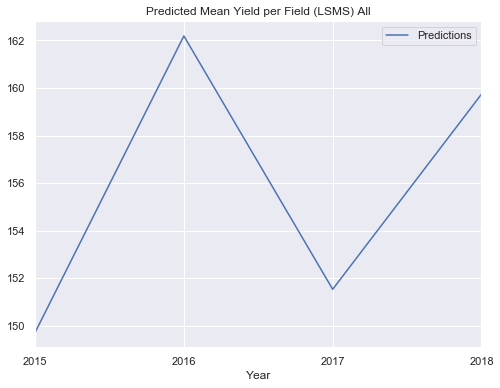

In [40]:
plt = df.from_dict(output).plot('Year','Predictions', xticks=[2015,2016,2017,2018], figsize=(8,6), title=f"Predicted Mean Yield per Field (LSMS) {region}")
plt.figure.savefig(f'Predictions_{region}.png',dpi=180)

In [41]:
actuals = pd.read_csv('Crop_Yield_CSA_formatted.csv')

In [42]:
actuals

,Crop,Zone,area_2013,area_2014,area_2015,area_2016,area_2017,area_2018,yield_2013,yield_2014,yield_2015,yield_2016,yield_2017,yield_2018
0,Teff,All,2.730273e+06,3016521.90,3016053.75,2866052.99,3017914.36,3023283.50,37652411.66,44186421.95,47506572.79,44713786.91,50204400.47,52834011.56
1,Barley,All,1.018753e+06,1019477.93,993918.89,944401.34,959273.36,951993.15,17816522.08,19082624.11,19533847.83,18567042.76,20249216.76,20529963.72
2,Wheat,All,1.627647e+06,1605653.90,1663837.58,1664564.62,1696082.59,1696907.05,34347061.22,39251741.35,42315887.16,42192572.23,45378523.39,46429657.12
3,Maize,All,2.013045e+06,1994813.80,2110209.61,2111518.23,2135571.85,2128948.91,61583175.95,64915402.92,72349551.02,71508354.11,78471746.57,83958872.44
4,Sorghum,All,1.711485e+06,1677486.33,1831600.45,1854710.93,1881970.73,1896389.29,36042619.65,38288701.03,43391342.61,43232997.52,47520956.04,51692525.40
5,Teff,Oromia,1.256565e+06,1397797.42,1427548.05,1369934.27,1441029.78,1443847.96,17535596.51,21040842.17,23254882.16,22156257.67,24737963.79,25814577.48
6,Barley,Oromia,4.485453e+05,471134.15,456192.42,439971.07,454662.78,451279.26,8977417.59,10239091.87,10275326.49,9800863.02,10939448.13,10884876.60
7,Wheat,Oromia,8.729718e+05,837000.48,875641.45,872252.80,898455.57,898682.57,20262900.10,23028513.78,24703210.41,24593751.44,26640244.46,26699177.73
8,Maize,Oromia,1.115957e+06,1083332.83,1129849.71,1125747.85,1142653.56,1146899.78,35908457.46,35954090.42,39441103.64,39538593.74,43620969.31,46767440.66
9,Sorghum,Oromia,6.756573e+05,669575.97,719399.70,759954.42,739781.80,735263.79,14898156.74,16739208.69,18146716.97,18846300.71,19166012.28,20810667.34


In [43]:
actuals = actuals[actuals['Zone'] == region]

In [44]:
actuals

,Crop,Zone,area_2013,area_2014,area_2015,area_2016,area_2017,area_2018,yield_2013,yield_2014,yield_2015,yield_2016,yield_2017,yield_2018
0,Teff,All,2730272.95,3016521.90,3016053.75,2866052.99,3017914.36,3023283.50,37652411.66,44186421.95,47506572.79,44713786.91,50204400.47,52834011.56
1,Barley,All,1018752.94,1019477.93,993918.89,944401.34,959273.36,951993.15,17816522.08,19082624.11,19533847.83,18567042.76,20249216.76,20529963.72
2,Wheat,All,1627647.16,1605653.90,1663837.58,1664564.62,1696082.59,1696907.05,34347061.22,39251741.35,42315887.16,42192572.23,45378523.39,46429657.12
3,Maize,All,2013044.93,1994813.80,2110209.61,2111518.23,2135571.85,2128948.91,61583175.95,64915402.92,72349551.02,71508354.11,78471746.57,83958872.44
4,Sorghum,All,1711485.04,1677486.33,1831600.45,1854710.93,1881970.73,1896389.29,36042619.65,38288701.03,43391342.61,43232997.52,47520956.04,51692525.40


In [45]:
y_ = ['2013','2014','2015','2016','2017','2018']
for y in y_:
    actuals[f'{y}'] = actuals[f'yield_{y}']/actuals[f'area_{y}']

/anaconda3/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
per_cols = [i for i in actuals.columns if i in y_]

In [47]:
actuals = actuals[per_cols]

In [48]:
actuals = actuals.transpose().reset_index().rename(columns={'index':'Year'})
#actuals['Actuals'] = actuals[0]+actuals[1]+actuals[2]+actuals[3]+actuals[4]

In [49]:
actuals

,Year,0,1,2,3,4
0,2013,13.790713,17.488560,21.102277,30.592052,21.059267
1,2014,14.648136,18.718036,24.445954,32.542086,22.825045
2,2015,15.751235,19.653362,25.432703,34.285481,23.690397
3,2016,15.601172,19.660119,25.347512,33.865847,23.309831
4,2017,16.635462,21.108912,26.754902,36.745074,25.250635
5,2018,17.475705,21.565243,27.361344,39.436772,27.258393


In [50]:
if region == 'All':
    cols_ = [0,1,2,3,4]
elif region == 'Oromia':
    cols_ = [5,6,7,8,9]
elif region == 'Gambela':
    cols_ = [10,11,12,13,14]
    
actuals['Actuals'] = actuals[cols_].mean(axis=1)

In [51]:
actuals = actuals[actuals['Year'].isin(['2015','2016','2017','2018'])]

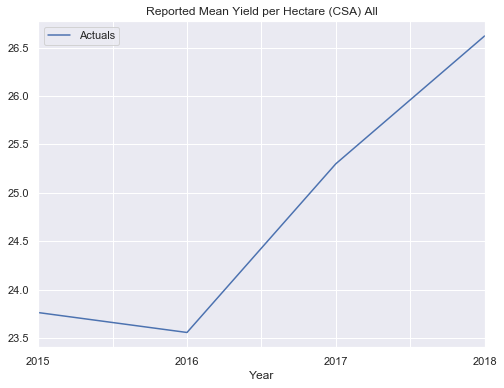

In [52]:
plt = actuals.plot('Year','Actuals', kind='line', figsize=(8,6), title=f'Reported Mean Yield per Hectare (CSA) {region}')
plt.figure.savefig(f'Actuals_{region}.png',dpi=180)